CSV en esta carpeta (.): 15
BPE_100uM_auto_sam1_mes1.csv
BPE_100uM_auto_sam1_mes2.csv
BPE_100uM_auto_sam1_mes3.csv
BPE_10uM_auto_sam2_mes1.csv
BPE_10uM_auto_sam2_mes2.csv
BPE_10uM_auto_sam2_mes3.csv
BPE_1mM_auto_sam1_mes1.csv
BPE_1mM_auto_sam1_mes2.csv
BPE_1mM_auto_sam1_mes3.csv
BPE_1uM_auto_sam2_mes1.csv
BPE_1uM_auto_sam2_mes2.csv
BPE_1uM_auto_sam2_mes3.csv
EtOH_auto_sam1.csv
EtOH_auto_sam2.csv
EtOH_auto_sam3.csv

=== Conteo por concentración (debería ser 3) ===
100 uM: n=3
10 uM: n=3
1 uM: n=3


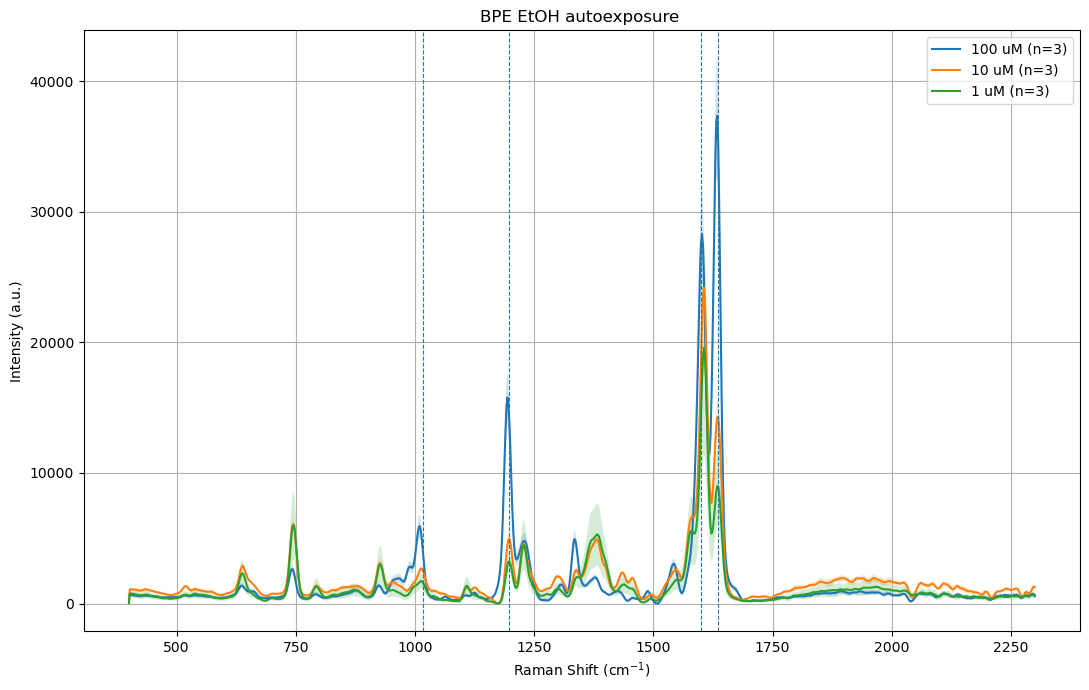

In [37]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "."  # notebook en Triplicates/Correct

EXCLUDE_1mM = True   # <- ponlo en False si algún día quieres volver a incluirlo

def load_csv(path):
    df = pd.read_csv(path, header=None, names=["Shift_cm1","Intensity_au"]).dropna()
    df["Shift_cm1"] = pd.to_numeric(df["Shift_cm1"], errors="coerce")
    df["Intensity_au"] = pd.to_numeric(df["Intensity_au"], errors="coerce")
    df = df.dropna().sort_values("Shift_cm1")
    return df["Shift_cm1"].values, df["Intensity_au"].values

files = [f for f in os.listdir(base_dir) if f.lower().endswith(".csv")]
print(f"CSV en esta carpeta ({base_dir}): {len(files)}")
print("\n".join(sorted(files)))

pat = re.compile(r"^BPE_(\d+(?:\.\d+)?)([mun]?M)_auto_.*\.csv$", re.IGNORECASE)

def conc_to_M(value, unit):
    unit = unit.lower()
    if unit == "m":  factor = 1.0
    elif unit == "mm": factor = 1e-3
    elif unit == "um": factor = 1e-6
    elif unit == "nm": factor = 1e-9
    else: raise ValueError(f"Unidad no reconocida: {unit}")
    return float(value)*factor

def pretty_label(conc_M):
    if conc_M >= 1e-3: return f"{conc_M/1e-3:g} mM"
    if conc_M >= 1e-6: return f"{conc_M/1e-6:g} uM"
    if conc_M >= 1e-9: return f"{conc_M/1e-9:g} nM"
    return f"{conc_M:g} M"

groups = {}
for f in files:
    m = pat.match(f)
    if not m:
        continue

    val, unit = m.groups()
    conc_M = conc_to_M(val, unit)

    # ====== FILTRO: quitar 1 mM ======
    if EXCLUDE_1mM and conc_M >= 1e-3:
        continue

    label = pretty_label(conc_M)

    sh, it = load_csv(os.path.join(base_dir, f))
    groups.setdefault(conc_M, {"label": label, "files": [], "spectra": []})
    groups[conc_M]["files"].append(f)
    groups[conc_M]["spectra"].append((sh, it))

print("\n=== Conteo por concentración (debería ser 3) ===")
for conc_M in sorted(groups.keys(), reverse=True):
    info = groups[conc_M]
    print(f"{info['label']}: n={len(info['files'])}")

# media ± std
mean_spectra = {}
for conc_M, info in groups.items():
    spectra = info["spectra"]
    n = len(spectra)

    shift_common = spectra[0][0]
    all_int = []
    for sh, it in spectra:
        if len(sh) != len(shift_common) or np.max(np.abs(sh - shift_common)) > 1e-9:
            it = np.interp(shift_common, sh, it)
        all_int.append(it)

    all_int = np.array(all_int)
    mean = np.mean(all_int, axis=0)
    std  = np.std(all_int, axis=0, ddof=1) if n > 1 else np.zeros_like(mean)

    mean_spectra[conc_M] = {"label": info["label"], "n": n, "shift": shift_common, "mean": mean, "std": std}

plt.figure(figsize=(11,7))
for conc_M in sorted(mean_spectra.keys(), reverse=True):
    d = mean_spectra[conc_M]
    plt.plot(d["shift"], d["mean"], label=f'{d["label"]} (n={d["n"]})')
    plt.fill_between(d["shift"], d["mean"]-d["std"], d["mean"]+d["std"], alpha=0.20)

for p in [1017,1198,1600,1635]:
    plt.axvline(p, linestyle="--", linewidth=0.8)

title_extra = " " if EXCLUDE_1mM else ""
plt.title("BPE EtOH autoexposure" + title_extra)
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

EtOH files: ['EtOH_auto_sam1.csv', 'EtOH_auto_sam2.csv', 'EtOH_auto_sam3.csv']
BPE 1mM files: ['BPE_1mM_auto_sam1_mes1.csv', 'BPE_1mM_auto_sam1_mes2.csv', 'BPE_1mM_auto_sam1_mes3.csv']


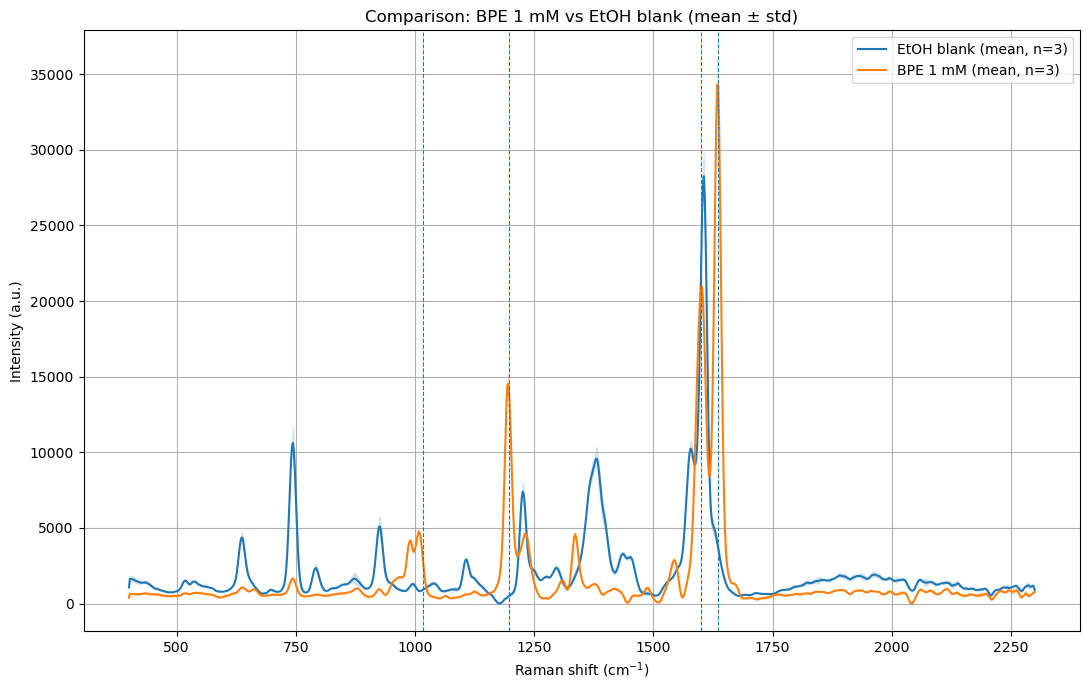

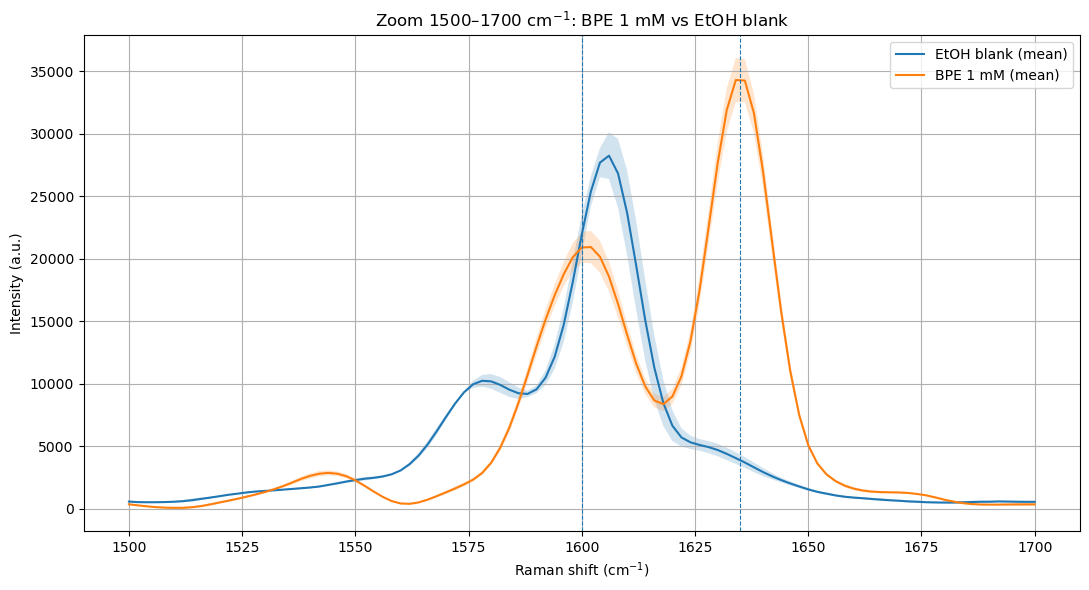

In [38]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "."

def load_csv(path):
    df = pd.read_csv(path, header=None, names=["Shift_cm1","Intensity_au"]).dropna()
    df["Shift_cm1"] = pd.to_numeric(df["Shift_cm1"], errors="coerce")
    df["Intensity_au"] = pd.to_numeric(df["Intensity_au"], errors="coerce")
    df = df.dropna().sort_values("Shift_cm1")
    return df["Shift_cm1"].values, df["Intensity_au"].values

def stack_mean_std(spectra):
    """
    spectra: list of (shift, intensity)
    Interpola todo a la malla del primero si hace falta.
    Devuelve shift_common, mean, std (ddof=1)
    """
    shift_common = spectra[0][0]
    all_int = []
    for sh, it in spectra:
        if len(sh) != len(shift_common) or np.max(np.abs(sh - shift_common)) > 1e-9:
            it = np.interp(shift_common, sh, it)
        all_int.append(it)
    all_int = np.array(all_int)
    mean = np.mean(all_int, axis=0)
    std = np.std(all_int, axis=0, ddof=1) if all_int.shape[0] > 1 else np.zeros_like(mean)
    return shift_common, mean, std

# =========================
# 1) Encontrar archivos EtOH (blanco)
# =========================
pat_etoh = re.compile(r"^EtOH_auto_sam(\d+)\.csv$", re.IGNORECASE)
etoh_files = [f for f in os.listdir(base_dir) if pat_etoh.match(f)]
etoh_files = sorted(etoh_files)

if len(etoh_files) == 0:
    raise RuntimeError("No encontré EtOH_auto_samX.csv en esta carpeta.")

etoh_spectra = [load_csv(os.path.join(base_dir, f)) for f in etoh_files]
sh_e, mean_e, std_e = stack_mean_std(etoh_spectra)

print("EtOH files:", etoh_files)

# =========================
# 2) Encontrar archivos BPE 1mM (triplicados)
# =========================
# Ej: BPE_1mM_auto_sam1_mes1.csv ...
pat_1mM = re.compile(r"^BPE_1mM_auto_sam1_mes(\d+)\.csv$", re.IGNORECASE)
bpe_1mM_files = [f for f in os.listdir(base_dir) if pat_1mM.match(f)]
bpe_1mM_files = sorted(bpe_1mM_files)

if len(bpe_1mM_files) == 0:
    raise RuntimeError("No encontré BPE_1mM_auto_sam1_mesX.csv en esta carpeta.")

bpe_1mM_spectra = [load_csv(os.path.join(base_dir, f)) for f in bpe_1mM_files]
sh_b, mean_b, std_b = stack_mean_std(bpe_1mM_spectra)

print("BPE 1mM files:", bpe_1mM_files)

# =========================
# 3) Plot global (todo el rango)
# =========================
plt.figure(figsize=(11,7))

plt.plot(sh_e, mean_e, label=f"EtOH blank (mean, n={len(etoh_files)})")
plt.fill_between(sh_e, mean_e-std_e, mean_e+std_e, alpha=0.20)

plt.plot(sh_b, mean_b, label=f"BPE 1 mM (mean, n={len(bpe_1mM_files)})")
plt.fill_between(sh_b, mean_b-std_b, mean_b+std_b, alpha=0.20)

for p in [1017, 1198, 1600, 1635]:
    plt.axvline(p, linestyle="--", linewidth=0.8)

plt.title("Comparison: BPE 1 mM vs EtOH blank (mean ± std)")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 4) Zoom región 1500–1700 cm^-1
# =========================
plt.figure(figsize=(11,6))

mask_e = (sh_e >= 1500) & (sh_e <= 1700)
mask_b = (sh_b >= 1500) & (sh_b <= 1700)

plt.plot(sh_e[mask_e], mean_e[mask_e], label="EtOH blank (mean)")
plt.fill_between(sh_e[mask_e], (mean_e-std_e)[mask_e], (mean_e+std_e)[mask_e], alpha=0.20)

plt.plot(sh_b[mask_b], mean_b[mask_b], label="BPE 1 mM (mean)")
plt.fill_between(sh_b[mask_b], (mean_b-std_b)[mask_b], (mean_b+std_b)[mask_b], alpha=0.20)

for p in [1600, 1635]:
    plt.axvline(p, linestyle="--", linewidth=0.8)

plt.title("Zoom 1500–1700 cm$^{-1}$: BPE 1 mM vs EtOH blank")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "."

# Picos candidatos típicos de BPE (elige uno para el LOD final)
peak_center_cm1 = 1635 # cm^-1 (cámbialo a 1198 o 1017 si quieres)

# Ventana de integración del pico: [center - win, center + win]
# (12 cm^-1 suele ir bien; ajusta si el pico es más ancho/estrecho)
integrate_halfwidth_cm1 = 8 # cm^-1

# Ventanas laterales para estimar baseline (para recta)
# izquierda: [center - left_far, center - left_near]
# derecha:  [center + right_near, center + right_far]
left_near_cm1, left_far_cm1   = 8, 18
right_near_cm1, right_far_cm1 = 8, 18

# Factores ICH Q2
k_LOD = 3.3
k_LOQ = 10.0

In [40]:
def load_csv(path):
    df = pd.read_csv(path, header=None, names=["Shift_cm1","Intensity_au"]).dropna()
    df["Shift_cm1"] = pd.to_numeric(df["Shift_cm1"], errors="coerce")
    df["Intensity_au"] = pd.to_numeric(df["Intensity_au"], errors="coerce")
    df = df.dropna().sort_values("Shift_cm1")
    return df["Shift_cm1"].values, df["Intensity_au"].values

pat_bpe = re.compile(r"^BPE_(\d+(?:\.\d+)?)([mun]?M)_auto_sam(\d+)_mes(\d+)\.csv$", re.IGNORECASE)
pat_blank = re.compile(r"^EtOH_auto_sam(\d+)\.csv$", re.IGNORECASE)

def conc_to_M(value, unit):
    unit = unit.lower()
    if unit == "m": factor = 1.0
    elif unit == "mm": factor = 1e-3
    elif unit == "um": factor = 1e-6
    elif unit == "nm": factor = 1e-9
    else: raise ValueError(f"Unidad no reconocida: {unit}")
    return float(value)*factor

def label_from_M(conc_M):
    if conc_M >= 1e-3: return f"{conc_M/1e-3:g} mM"
    if conc_M >= 1e-6: return f"{conc_M/1e-6:g} uM"
    if conc_M >= 1e-9: return f"{conc_M/1e-9:g} nM"
    return f"{conc_M:g} M"

files = [f for f in os.listdir(base_dir) if f.lower().endswith(".csv")]

bpe_records, blank_records = [], []

for f in files:
    mb = pat_bpe.match(f)
    if mb:
        val, unit, sam, mes = mb.groups()
        conc_M = conc_to_M(val, unit)
        sh, it = load_csv(os.path.join(base_dir, f))
        bpe_records.append({
            "file": f, "conc_M": conc_M, "conc_label": label_from_M(conc_M),
            "sam": int(sam), "mes": int(mes), "shift": sh, "int": it
        })
        continue

    mk = pat_blank.match(f)
    if mk:
        sh, it = load_csv(os.path.join(base_dir, f))
        blank_records.append({
            "file": f, "sam": int(mk.group(1)),
            "shift": sh, "int": it
        })

print("BPE files:", len(bpe_records))
print("EtOH blank files:", len(blank_records))

display(pd.DataFrame([{"file":r["file"],"conc":r["conc_label"],"sam":r["sam"],"mes":r["mes"]} for r in bpe_records]).sort_values(["conc","sam","mes"]))
display(pd.DataFrame([{"file":r["file"],"sam":r["sam"]} for r in blank_records]).sort_values("sam"))

BPE files: 12
EtOH blank files: 3


,file,conc,sam,mes
8,BPE_1mM_auto_sam1_mes1.csv,1 mM,1,1
7,BPE_1mM_auto_sam1_mes2.csv,1 mM,1,2
9,BPE_1mM_auto_sam1_mes3.csv,1 mM,1,3
0,BPE_1uM_auto_sam2_mes1.csv,1 uM,2,1
6,BPE_1uM_auto_sam2_mes2.csv,1 uM,2,2
5,BPE_1uM_auto_sam2_mes3.csv,1 uM,2,3
1,BPE_10uM_auto_sam2_mes1.csv,10 uM,2,1
11,BPE_10uM_auto_sam2_mes2.csv,10 uM,2,2
10,BPE_10uM_auto_sam2_mes3.csv,10 uM,2,3
4,BPE_100uM_auto_sam1_mes1.csv,100 uM,1,1


,file,sam
1,EtOH_auto_sam1.csv,1
2,EtOH_auto_sam2.csv,2
0,EtOH_auto_sam3.csv,3


In [41]:
def integrated_peak_area_anchor(shift_cm1, intensity_au,
                                peak_center_cm1,
                                integrate_halfwidth_cm1,
                                left_near_cm1, left_far_cm1,
                                right_near_cm1, right_far_cm1):
    sh = np.asarray(shift_cm1)
    it = np.asarray(intensity_au)

    mL = (sh >= peak_center_cm1 - left_far_cm1) & (sh <= peak_center_cm1 - left_near_cm1)
    mR = (sh >= peak_center_cm1 + right_near_cm1) & (sh <= peak_center_cm1 + right_far_cm1)
    if np.sum(mL) < 3 or np.sum(mR) < 3:
        return np.nan, (np.nan, np.nan)

    # puntos ancla (promedios)
    xL, yL = np.mean(sh[mL]), np.mean(it[mL])
    xR, yR = np.mean(sh[mR]), np.mean(it[mR])

    if np.isclose(xR, xL):
        return np.nan, (np.nan, np.nan)

    # baseline lineal que une los dos anclajes
    a = (yR - yL) / (xR - xL)
    b = yL - a*xL

    # ventana de integración
    x0 = peak_center_cm1 - integrate_halfwidth_cm1
    x1 = peak_center_cm1 + integrate_halfwidth_cm1
    mw = (sh >= x0) & (sh <= x1)
    if np.sum(mw) < 5:
        return np.nan, (a, b)

    xw = sh[mw]
    yw = it[mw]
    ycorr = yw - (a*xw + b)

    A = np.trapz(ycorr, xw)  # a.u.*cm^-1
    return A, (a, b)

In [42]:
blank_rows = []
for r in blank_records:
    A, (a,b0) = integrated_peak_area_anchor(
        r["shift"], r["int"],
        peak_center_cm1,
        integrate_halfwidth_cm1,
        left_near_cm1, left_far_cm1,
        right_near_cm1, right_far_cm1
    )
    blank_rows.append({
        "file": r["file"],
        "sam": r["sam"],
        "peak_center_cm1": peak_center_cm1,
        "area_blank_A (a.u.*cm^-1)": A
    })

df_blank = pd.DataFrame(blank_rows).sort_values("sam")
display(df_blank)

A_blank = df_blank["area_blank_A (a.u.*cm^-1)"].values.astype(float)
Ablank_mean = np.mean(A_blank)
sigma_blank = np.std(A_blank, ddof=1) if len(A_blank) > 1 else 0.0

print("=== BLANCO EtOH (área) ===")
print(f"mean(A_blank) = {Ablank_mean:.6g} a.u.*cm^-1")
print(f"sigma_blank   = {sigma_blank:.6g} a.u.*cm^-1  (σ para LOD)")

,file,sam,peak_center_cm1,area_blank_A (a.u.*cm^-1)
1,EtOH_auto_sam1.csv,1,1635,-1859.8
2,EtOH_auto_sam2.csv,2,1635,-5046.8
0,EtOH_auto_sam3.csv,3,1635,-908.0


=== BLANCO EtOH (área) ===
mean(A_blank) = -2604.87 a.u.*cm^-1
sigma_blank   = 2167.66 a.u.*cm^-1  (σ para LOD)


In [43]:
bpe_rows = []
for r in bpe_records:
    A, (a,b0) = integrated_peak_area_anchor(
        r["shift"], r["int"],
        peak_center_cm1,
        integrate_halfwidth_cm1,
        left_near_cm1, left_far_cm1,
        right_near_cm1, right_far_cm1
    )
    bpe_rows.append({
        "file": r["file"],
        "conc_M": r["conc_M"],
        "conc_label": r["conc_label"],
        "sam": r["sam"],
        "mes": r["mes"],
        "peak_center_cm1": peak_center_cm1,
        "area_A (a.u.*cm^-1)": A
    })

df_meas = pd.DataFrame(bpe_rows).sort_values(["conc_M","sam","mes"])
display(df_meas)

# (opcional pero recomendable) quitar NaN antes de agrupar
df_meas_clean = df_meas.dropna(subset=["area_A (a.u.*cm^-1)"]).copy()

df_sum = (df_meas_clean.groupby(["conc_M","conc_label"], as_index=False)
          .agg(n=("area_A (a.u.*cm^-1)","count"),
               mean_area=("area_A (a.u.*cm^-1)","mean"),
               std_area=("area_A (a.u.*cm^-1)","std"))
          .sort_values("conc_M"))

print("=== RESUMEN POR CONCENTRACIÓN (área) ===")
display(df_sum)

,file,conc_M,conc_label,sam,mes,peak_center_cm1,area_A (a.u.*cm^-1)
0,BPE_1uM_auto_sam2_mes1.csv,0.000001,1 uM,2,1,1635,66210.0
6,BPE_1uM_auto_sam2_mes2.csv,0.000001,1 uM,2,2,1635,44473.6
5,BPE_1uM_auto_sam2_mes3.csv,0.000001,1 uM,2,3,1635,41175.0
1,BPE_10uM_auto_sam2_mes1.csv,0.000010,10 uM,2,1,1635,80250.0
11,BPE_10uM_auto_sam2_mes2.csv,0.000010,10 uM,2,2,1635,82364.4
10,BPE_10uM_auto_sam2_mes3.csv,0.000010,10 uM,2,3,1635,99209.0
4,BPE_100uM_auto_sam1_mes1.csv,0.000100,100 uM,1,1,1635,299459.6
2,BPE_100uM_auto_sam1_mes2.csv,0.000100,100 uM,1,2,1635,242761.8
3,BPE_100uM_auto_sam1_mes3.csv,0.000100,100 uM,1,3,1635,291157.0
8,BPE_1mM_auto_sam1_mes1.csv,0.001000,1 mM,1,1,1635,280662.8


=== RESUMEN POR CONCENTRACIÓN (área) ===


,conc_M,conc_label,n,mean_area,std_area
0,0.000001,1 uM,3,50619.533333,13602.101994
1,0.000010,10 uM,3,87274.466667,10389.537345
2,0.000100,100 uM,3,277792.800000,30620.442721
3,0.001000,1 mM,3,274819.066667,13580.217909


=== CALIBRACIÓN (área) SIN 1 mM ===
m = 2.22259e+09 (a.u.*cm^-1)/M
b = 56326.3 a.u.*cm^-1
R2 = 0.995308
Puntos usados (M): [1.e-06 1.e-05 1.e-04]


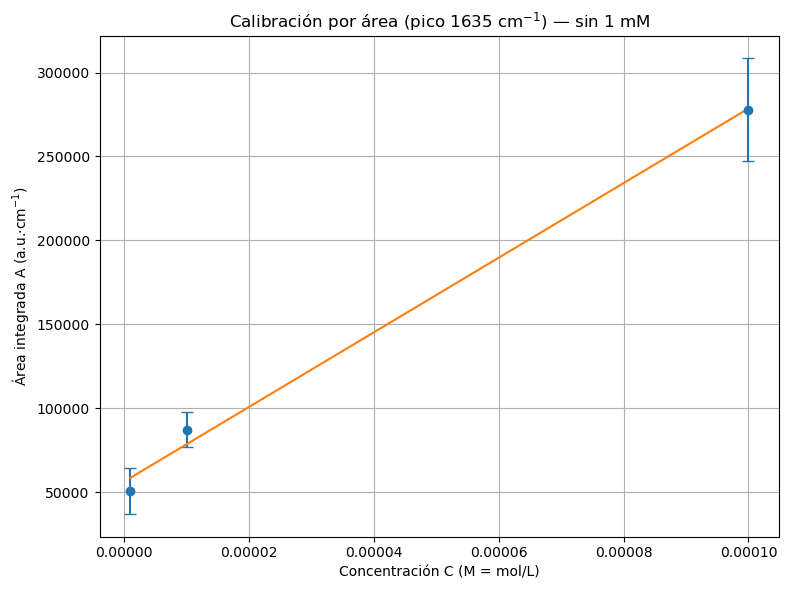

In [44]:
# (recomendado) quitar filas con NaN
df_sum2 = df_sum.dropna(subset=["conc_M","mean_area","std_area"]).copy()

# ====== FILTRO: quitar 1 mM (1e-3 M) ======
df_sum_no1mM = df_sum2[df_sum2["conc_M"] < 1e-3].copy()

# x = concentración en M, y = área media en a.u.*cm^-1
x = df_sum_no1mM["conc_M"].values.astype(float)        # M
y = df_sum_no1mM["mean_area"].values.astype(float)     # a.u.*cm^-1

m_slope, b_intercept = np.polyfit(x, y, 1)
y_fit = m_slope*x + b_intercept

# R^2
ss_res = np.sum((y - y_fit)**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

print("=== CALIBRACIÓN (área) SIN 1 mM ===")
print(f"m = {m_slope:.6g} (a.u.*cm^-1)/M")
print(f"b = {b_intercept:.6g} a.u.*cm^-1")
print(f"R2 = {R2:.6g}")
print("Puntos usados (M):", x)

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=df_sum_no1mM["std_area"].values, fmt="o", capsize=4)
x_line = np.linspace(np.min(x), np.max(x), 200)
plt.plot(x_line, m_slope*x_line + b_intercept)

plt.title(f"Calibración por área (pico {peak_center_cm1} cm$^{{-1}}$) — sin 1 mM")
plt.xlabel("Concentración C (M = mol/L)")
plt.ylabel("Área integrada A (a.u.·cm$^{-1}$)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# === LOD/LOQ usando la pendiente del rango lineal (sin 1 mM) ===
LOD_M = k_LOD * sigma_blank / m_slope
LOQ_M = k_LOQ * sigma_blank / m_slope

print("=== LOD/LOQ (área integrada, rango lineal 1–100 uM) ===")
print(f"sigma_blank = {sigma_blank:.6g} a.u.*cm^-1")
print(f"m (rango lineal) = {m_slope:.6g} (a.u.*cm^-1)/M")
print(f"LOD = {LOD_M:.6g} M = {LOD_M/1e-6:.3g} uM")
print(f"LOQ = {LOQ_M:.6g} M = {LOQ_M/1e-6:.3g} uM")

=== LOD/LOQ (área integrada, rango lineal 1–100 uM) ===
sigma_blank = 2167.66 a.u.*cm^-1
m (rango lineal) = 2.22259e+09 (a.u.*cm^-1)/M
LOD = 3.21844e-06 M = 3.22 uM
LOQ = 9.75285e-06 M = 9.75 uM


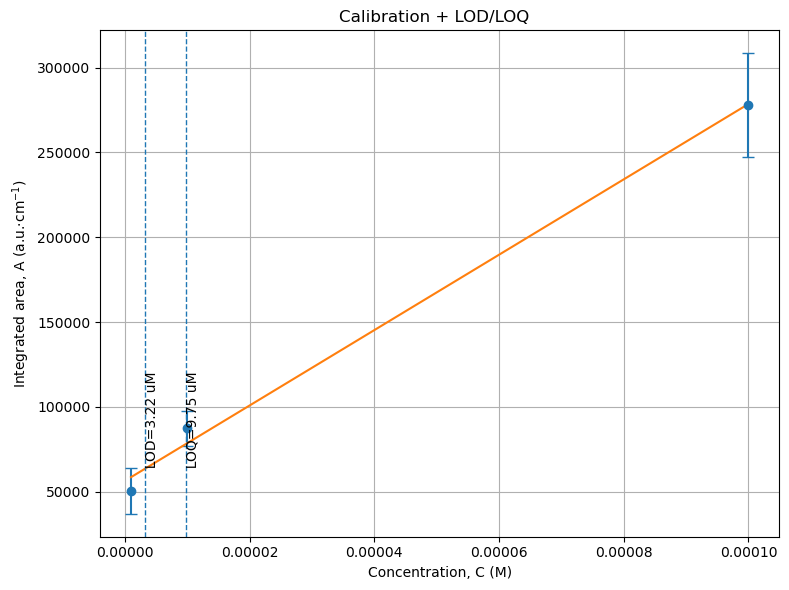

In [46]:
# ===== Plot calibración + LOD/LOQ (SIN 1 mM) =====

# usa los puntos del rango lineal
x = df_sum_no1mM["conc_M"].values.astype(float)          # M
y = df_sum_no1mM["mean_area"].values.astype(float)       # a.u.*cm^-1
yerr = df_sum_no1mM["std_area"].values.astype(float)

# línea de la recta en el rango lineal
x_line = np.linspace(np.min(x), np.max(x), 200)

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
plt.plot(x_line, m_slope*x_line + b_intercept)

# líneas verticales en LOD y LOQ
plt.axvline(LOD_M, linestyle="--", linewidth=1)
plt.axvline(LOQ_M, linestyle="--", linewidth=1)

# texto: ponlo cerca del mínimo de la recta para que no se te vaya fuera
y_text = np.min(m_slope*x_line + b_intercept)

plt.text(LOD_M, y_text, f"  LOD={format_conc_M(LOD_M)}", rotation=90, va="bottom")
plt.text(LOQ_M, y_text, f"  LOQ={format_conc_M(LOQ_M)}", rotation=90, va="bottom")

plt.title(f"Calibration + LOD/LOQ  ")
plt.xlabel("Concentration, C (M)")
plt.ylabel("Integrated area, A (a.u.·cm$^{-1}$)")
plt.grid(True)
plt.tight_layout()
plt.show()